In [1]:
import os
import numpy as np
import scanpy as sc
import scvi
import torch

/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [3]:
adata_ref = sc.read_h5ad("BRCA4.h5ad")
adata_ref
adata_ref.obs["SampleID"] = adata_ref.obs["orig.ident"]

In [4]:
adata_query = sc.read_h5ad("cellranger_filter_count.h5ad")

In [5]:
adata = adata_ref.concatenate(adata_query,  batch_categories=["ref", "query"])

/tmp/ipykernel_7103/4127391411.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_ref.concatenate(adata_query,  batch_categories=["ref", "query"])


In [6]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="batch",
    subset=True,
)

In [7]:
adata

AnnData object with n_obs × n_vars = 126613 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'subtype', 'celltype_subset', 'celltype_minor', 'celltype_major', 'SampleID', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase', 'batch'
    var: 'name-0-query', 'name-1-query', 'name-2-query', 'name-ref', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'

In [8]:
adata.layers["counts"] = adata.X.copy()

In [9]:
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key="SampleID")

/home/zhepan/miniconda3/envs/scvi/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [11]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/63:   0%|          | 0/63 [00:00<?, ?it/s]

/home/zhepan/miniconda3/envs/scvi/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 63/63: 100%|██████████| 63/63 [27:59<00:00, 77.51s/it, v_num=1, train_loss_step=705, train_loss_epoch=631]

`Trainer.fit` stopped: `max_epochs=63` reached.


Epoch 63/63: 100%|██████████| 63/63 [27:59<00:00, 26.65s/it, v_num=1, train_loss_step=705, train_loss_epoch=631]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

In [13]:
adata.obs['celltype_major'].value_counts

<bound method IndexOpsMixin.value_counts of CID3586_AAGACCTCAGCATGAG-ref    Endothelial
CID3586_AAGGTTCGTAGTACCT-ref    Endothelial
CID3586_ACCAGTAGTTGTGGCC-ref    Endothelial
CID3586_ACCCACTAGATGTCGG-ref    Endothelial
CID3586_ACTGATGGTCAACTGT-ref    Endothelial
                                   ...     
TTGTCAGTTAGTGGG-2-query                 NaN
TTGTCAGTTCCATGA-2-query                 NaN
TTGTCAGTTCTGTTT-2-query                 NaN
TTGTCATCACAGTAC-2-query                 NaN
TTGTCATCAGCGATT-2-query                 NaN
Name: celltype_major, Length: 126613, dtype: category
Categories (9, object): ['B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', ..., 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells']>

In [14]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)
sc.tl.umap(adata,min_dist=0.2)

/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

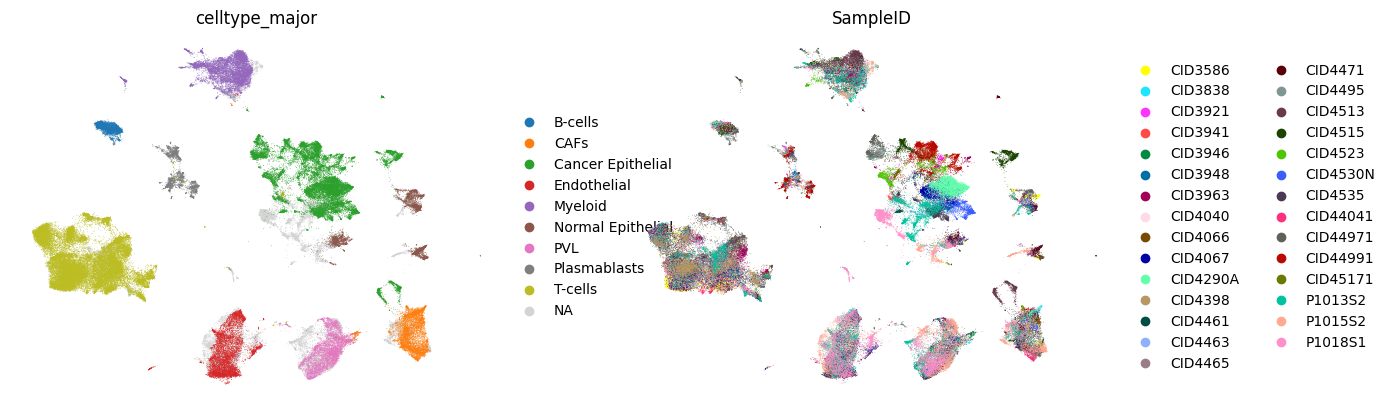

In [15]:
sc.pl.embedding(adata, basis='umap', color=["celltype_major","SampleID"], frameon=False, ncols=2)

In [16]:
SCANVI_CELLTYPE_KEY = "celltype_raw"

adata.obs[SCANVI_CELLTYPE_KEY] = "Unknown"
ref_mask = adata.obs["batch"] == "ref"
adata.obs[SCANVI_CELLTYPE_KEY][ref_mask] = adata.obs.celltype_major[
    ref_mask
].values

/tmp/ipykernel_7103/734315981.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[SCANVI_CELLTYPE_KEY][ref_mask] = adata.obs.celltype_major[


In [17]:
adata.obs['celltype_raw'].value_counts

<bound method IndexOpsMixin.value_counts of CID3586_AAGACCTCAGCATGAG-ref    Endothelial
CID3586_AAGGTTCGTAGTACCT-ref    Endothelial
CID3586_ACCAGTAGTTGTGGCC-ref    Endothelial
CID3586_ACCCACTAGATGTCGG-ref    Endothelial
CID3586_ACTGATGGTCAACTGT-ref    Endothelial
                                   ...     
TTGTCAGTTAGTGGG-2-query             Unknown
TTGTCAGTTCCATGA-2-query             Unknown
TTGTCAGTTCTGTTT-2-query             Unknown
TTGTCATCACAGTAC-2-query             Unknown
TTGTCATCAGCGATT-2-query             Unknown
Name: celltype_raw, Length: 126613, dtype: object>

In [18]:
np.unique(adata.obs[SCANVI_CELLTYPE_KEY], return_counts=True)

(array(['B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid',
        'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells', 'Unknown'],
       dtype=object),
 array([ 3206,  6573, 24489,  7605,  9675,  4355,  5423,  3524, 35214,
        26549]))

In [19]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="celltype_raw",
    unlabeled_category="Unknown",
)

In [20]:
scanvi_model.train(max_epochs=20, n_samples_per_label=1000)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20:  95%|█████████▌| 19/20 [54:15<04:20, 260.09s/it, v_num=1, train_loss_step=665, train_loss_epoch=691]

In [ ]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

In [ ]:
SCANVI_PREDICTION_KEY = "C_scANVI"
adata.obs[SCANVI_PREDICTION_KEY] = scanvi_model.predict(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(adata,resolution=0.1)
sc.tl.umap(adata,min_dist=0.2)

/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

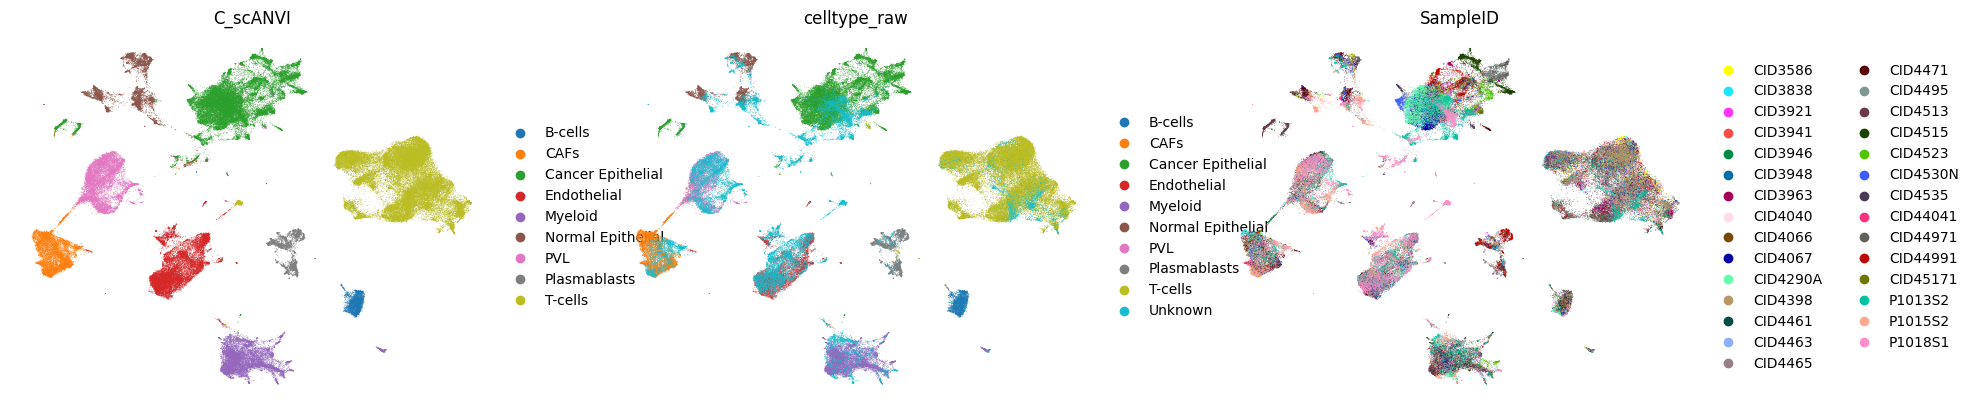

In [ ]:
sc.pl.umap(adata, color=[SCANVI_PREDICTION_KEY, "celltype_raw", "SampleID"], frameon=False, ncols=3)

In [ ]:
adata_query = adata[adata.obs["batch"] == "query"]

/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

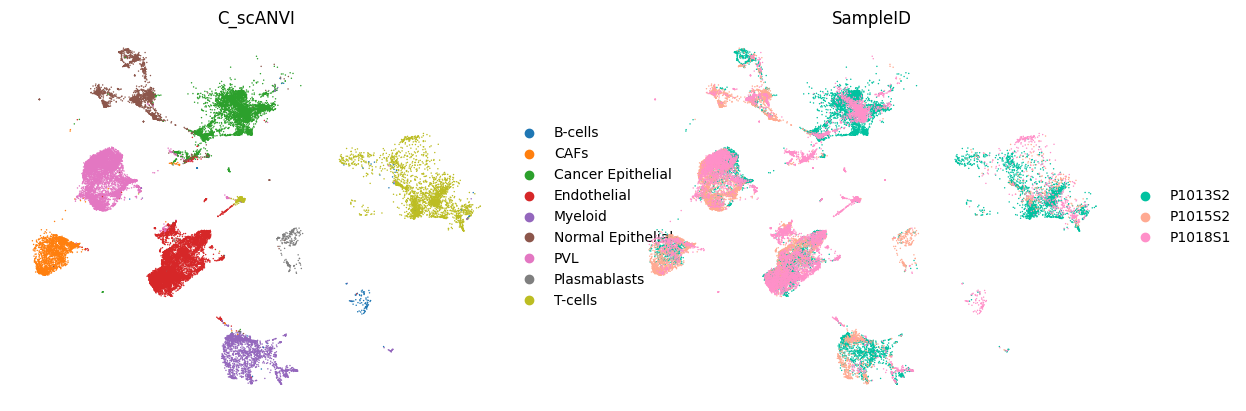

In [ ]:
sc.pl.umap(adata_query, color=[SCANVI_PREDICTION_KEY, "SampleID"], frameon=False, ncols=2, )

In [ ]:
adata_query.obs[SCANVI_PREDICTION_KEY].to_csv('scanvi_BCatlas.csv')

In [ ]:
adata_inter = sc.read_h5ad("cellranger_filter_count.h5ad")

In [ ]:
sc.pp.highly_variable_genes(
    adata_inter,
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="batch",
    subset=True,
)

In [ ]:
adata_inter.layers["counts"] = adata_inter.X.copy()

In [ ]:
scvi.model.SCVI.setup_anndata(adata_inter, layer='counts', batch_key="SampleID")
model = scvi.model.SCVI(adata_inter, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()


In [ ]:
SCVI_LATENT_KEY = "X_scVI"
adata_inter.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
SCVI_MDE_KEY = "X_scVI_MDE"


In [ ]:
adata_inter.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata_inter.obsm[SCVI_LATENT_KEY])


In [ ]:
sc.pp.neighbors(adata_inter, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_inter,resolution=0.2)
sc.tl.umap(adata_inter,min_dist=0.2)


In [ ]:
sc.pl.embedding(adata_inter, basis='umap', color=["celltype_major","SampleID"], frameon=False, ncols=2)

In [ ]:
adata_inter.write_h5ad("cellranger_filter_scvi.h5ad")